# IMPLEMENTER UN MODELE DE SCORING

## Notebook Analyse Exploratoire

Une société financière propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifier la demande en crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

Ma mission en tant que data scientist:

---


- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

Dans ce premier notebook, nous allons commencer par analyser les données et selectionner les features ayant la probabilité la plus élevée d'avoir un impact sur la variable cible.

# Import des librairies et des datasets

In [1]:
# Import des librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn as sk

from sklearn.preprocessing import PowerTransformer # transforme les données déséquilibrées en données gaussienne
from scipy import stats #pour la regression linéaire
from scipy.stats import f_oneway #pour l'ANOVA
import statsmodels.formula.api  #pour l'ANOVA
import statsmodels.api  #pour l'ANOVA
from scipy.stats import chi2_contingency #pour le chi2
from sklearn import decomposition

import warnings
warnings.filterwarnings('ignore')

# Import des datasets

# df principal, données statiques pour toutes les applications.
df_application_train = pd.read_csv('application_train.csv')
df_application_test = pd.read_csv('application_test.csv')

# crédits antérieurs des clients fournis par d'autres institutions financières.
df_bureau = pd.read_csv('bureau.csv')

# soldes mensuels des crédits précédents dans Credit Bureau.
df_bureau_balance = pd.read_csv('bureau_balance.csv')

# instantanés du solde mensuel des précédents points de vente et des prêts en espèces que le demandeur avait avec Home Credit.
df_POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')

# instantanés du solde mensuel des cartes de crédit précédentes que le demandeur a avec Home Credit.
df_credit_card_balance = pd.read_csv('credit_card_balance.csv')

# toutes les demandes antérieures de crédit immobilier des clients qui ont des crédits dans notre échantillon.
df_previous_application = pd.read_csv('previous_application.csv')

# historique de remboursement des crédits précédemment décaissés en Crédit Logement relatifs aux crédits de notre échantillon.
df_installments_payments = pd.read_csv('installments_payments.csv')

# descriptions des colonnes des différents fichiers de données.
df_HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv')

# 1. ANALYSE EXPLORATOIRE DES DONNES

In [2]:
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.max_rows', None) # affiche toutes les lignes

In [3]:
# df qui indique la description des features
df_HomeCredit_columns_description

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [4]:
pd.set_option('display.max_rows', 10) # affiche les lignes 10 premiers lignes

In [5]:
# Affichage de toutes les colonnes du df
df_application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [6]:
# Dimension du df
df_application_train.shape

(307511, 122)

In [7]:
# Types de variables contenu dans le df
df_application_train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [8]:
# Taux de données manquantes du df
df_application_train.isna().mean()

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY     0.135016
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016
AMT_REQ_CREDIT_BUREAU_MON     0.135016
AMT_REQ_CREDIT_BUREAU_QRT     0.135016
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016
Length: 122, dtype: float64

In [9]:
# Description statistiques des données quantitatives
df_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

# 1.1 Analyse univariées

### Analyse qualitative

Clients normaux : 282686 individus, soit 91.93 % du dataset
Clients avec des difficultés de paiement : 24825 individus, soit 8.07 % du dataset
Ratio de déséquilibre: 11.387150050352467


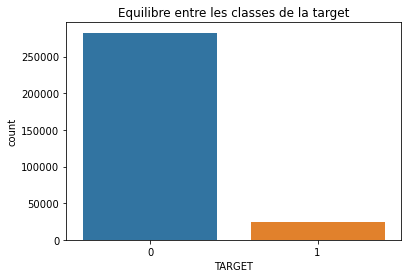

In [10]:
# Visualisation de l'équilibre entre classe de la variable cible
sns.countplot(data = df_application_train, x='TARGET')
plt.title('Equilibre entre les classes de la target')

x = df_application_train
clients_normaux = round(x['TARGET'].value_counts()[0])
clients_complexes = round(x['TARGET'].value_counts()[1])
clients_normaux_p = round(x['TARGET'].value_counts()[0]/len(x) * 100,2)
clients_complexes_p = round(x['TARGET'].value_counts()[1]/len(x) * 100,2)
imb_ratio = (x['TARGET'].value_counts()[0]/len(x))/(x['TARGET'].value_counts()[1]/len(x))

print(f"Clients normaux : {clients_normaux} individus, soit {clients_normaux_p} % du dataset")
print(f"Clients avec des difficultés de paiement : {clients_complexes} individus, soit {clients_complexes_p} % du dataset")
print(f'Ratio de déséquilibre: {imb_ratio}')

In [11]:
# Répartition selon le type de prêts
df_application_train['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

In [12]:
# Répartition selon la possession de voitures personnelles
df_application_train['FLAG_OWN_CAR'].value_counts()

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

In [13]:
# Répartition selon la possession de biens immobiliers possédés
df_application_train['FLAG_OWN_REALTY'].value_counts()

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64

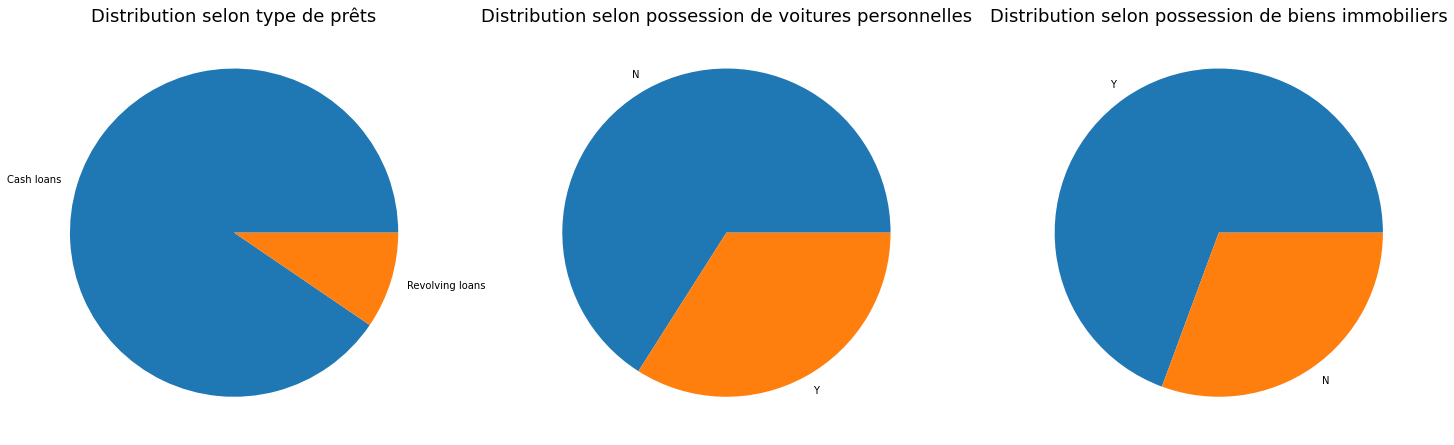

In [14]:
plt.figure(figsize=(25,10))
plt.subplot(1, 3, 1)
my_data = df_application_train['NAME_CONTRACT_TYPE'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon type de prêts", fontsize=18)

plt.subplot(1, 3, 2)
my_data = df_application_train['FLAG_OWN_CAR'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon possession de voitures personnelles", fontsize=18)

plt.subplot(1, 3, 3)
my_data = df_application_train['FLAG_OWN_REALTY'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon possession de biens immobiliers", fontsize=18)
plt.show()

In [15]:
# Répartition selon le sexe
df_application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [16]:
# Répartition selon la situation familiale
df_application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [17]:
# Répartition selon si le client était joignable sur son téléphone mobile (1=YES, 0=NO)
df_application_train['FLAG_CONT_MOBILE'].value_counts()

1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64

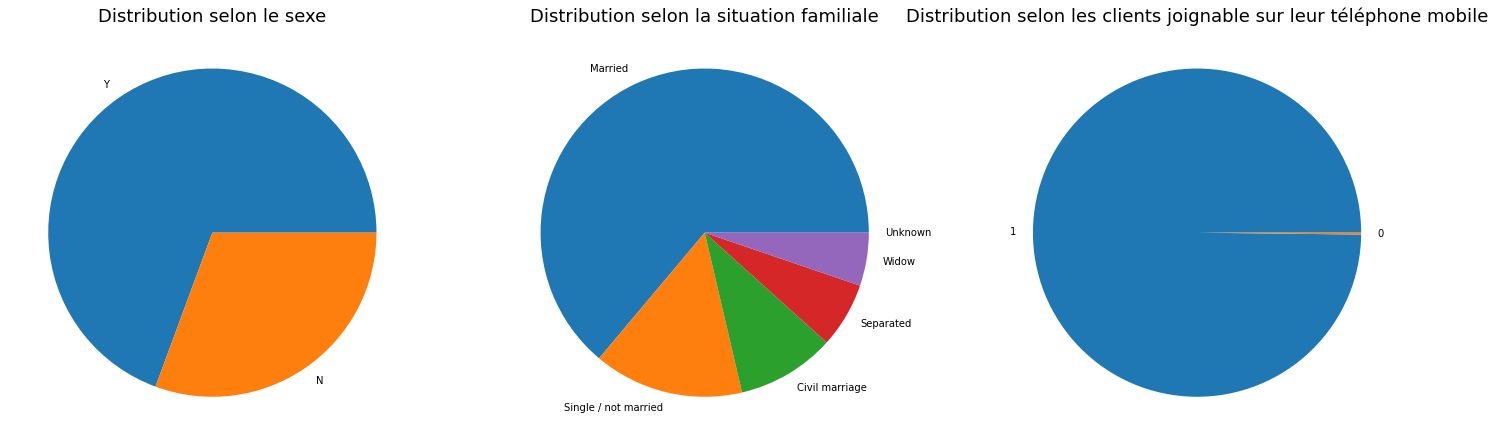

In [18]:
plt.figure(figsize=(25,10))
plt.subplot(1, 3, 1)
y_data = df_application_train['CODE_GENDER'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon le sexe", fontsize=18)

plt.subplot(1, 3, 2)
my_data = df_application_train['NAME_FAMILY_STATUS'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon la situation familiale", fontsize=18)

plt.subplot(1, 3, 3)
my_data = df_application_train['FLAG_CONT_MOBILE'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon les clients joignable sur leur téléphone mobile", fontsize=18)
plt.show()

In [19]:
# Répartition selon le niveau d'éducation le plus élevé atteint 
df_application_train['NAME_EDUCATION_TYPE'].value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [20]:
# Répartition selon le type de revenu
df_application_train['NAME_INCOME_TYPE'].value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

In [21]:
# Répartition selon le type de profession
df_application_train['OCCUPATION_TYPE'].value_counts()

Laborers                55186
Sales staff             32102
Core staff              27570
Managers                21371
Drivers                 18603
                        ...  
Waiters/barmen staff     1348
Secretaries              1305
Realty agents             751
HR staff                  563
IT staff                  526
Name: OCCUPATION_TYPE, Length: 18, dtype: int64

In [22]:
# Répartition selon l'évaluation de la région où vit le client (1,2,3)
df_application_train['REGION_RATING_CLIENT'].value_counts()

2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64

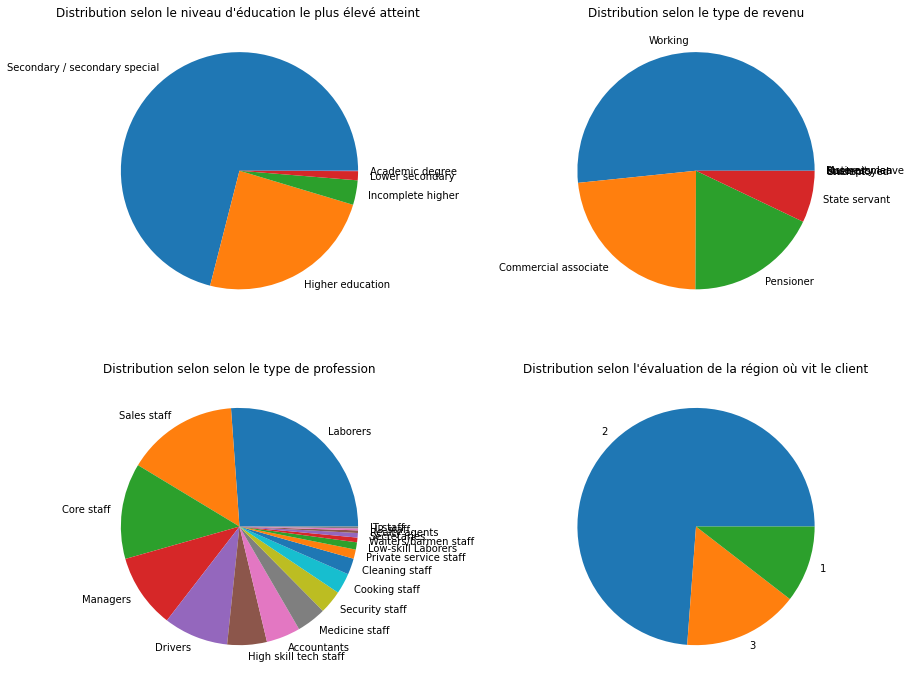

In [23]:
plt.figure(figsize=(15,12))
plt.subplot(2, 2, 1)
my_data = df_application_train['NAME_EDUCATION_TYPE'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon le niveau d'éducation le plus élevé atteint ")

plt.subplot(2, 2, 2)
my_data = df_application_train['NAME_INCOME_TYPE'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon le type de revenu")

plt.subplot(2, 2, 3)
my_data = df_application_train['OCCUPATION_TYPE'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon selon le type de profession")

plt.subplot(2, 2, 4)
my_data = df_application_train['REGION_RATING_CLIENT'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon l'évaluation de la région où vit le client")

plt.show()

### Analyse quantitative

In [24]:
# Répartition selon le montant des crédits
df_application_train['AMT_CREDIT'].value_counts()

450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
859581.0        1
2129634.0       1
1860813.0       1
1013836.5       1
1500642.0       1
Name: AMT_CREDIT, Length: 5603, dtype: int64

Text(0.5, 1.0, 'Distribution du montant des crédits')

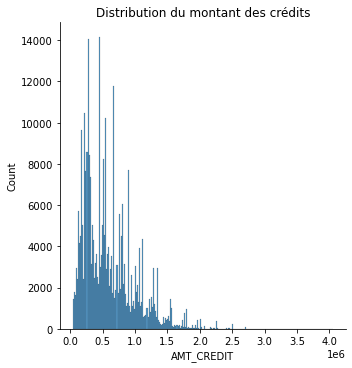

In [25]:
# Distribution du montant des crédits
sns.displot(df_application_train['AMT_CREDIT'])
plt.title('Distribution du montant des crédits')

In [26]:
df_application_train['AMT_CREDIT'].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

In [27]:
# Catégorie selon le salaire
df_application_train['CREDIT_CAT'] = pd.cut(df_application_train['AMT_CREDIT'], 
                                         bins=[0, 2.700000e+05, 5.135310e+05, 8.086500e+05, 4.050000e+06],
                                         labels=["0 à 272k$", "270 à 513k$", "513 à 808k$", "Plus de 4M$"])
df_application_train['CREDIT_CAT'].value_counts()

0 à 272k$      78421
513 à 808k$    77786
Plus de 4M$    75876
270 à 513k$    75428
Name: CREDIT_CAT, dtype: int64

In [28]:
# Distribution selon le montant des traites annuelles
df_application_train['AMT_ANNUITY'].value_counts()

9000.0     6385
13500.0    5514
6750.0     2279
10125.0    2035
37800.0    1602
           ... 
4635.0        1
65209.5       1
70920.0       1
85792.5       1
51331.5       1
Name: AMT_ANNUITY, Length: 13672, dtype: int64

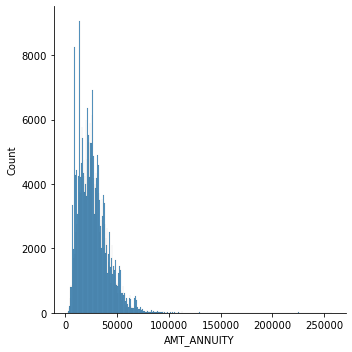

In [29]:
sns.displot(df_application_train['AMT_ANNUITY'])

In [30]:
# Distribution selon les revenus totaux
df_application_train['AMT_INCOME_TOTAL'].value_counts()

135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
83479.5         1
44955.0         1
78916.5         1
37008.0         1
131125.5        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

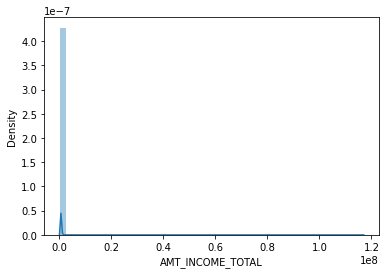

In [31]:
sns.distplot(df_application_train['AMT_INCOME_TOTAL'])

In [32]:
df_application_train['AMT_INCOME_TOTAL'].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [33]:
# NaN pour AMT_INCOME_TOTAL à 1.170000e+08
df_application_train['AMT_INCOME_TOTAL'].replace(1.170000e+08, np.nan, inplace= True)

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

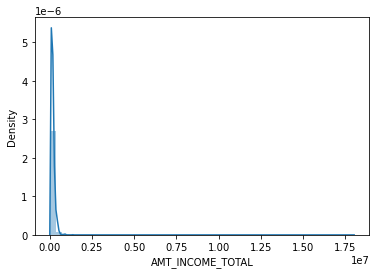

In [34]:
sns.distplot(df_application_train['AMT_INCOME_TOTAL'])

In [35]:
df_application_train['AMT_INCOME_TOTAL'].describe()

count    3.075100e+05
mean     1.684180e+05
std      1.088118e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.800009e+07
Name: AMT_INCOME_TOTAL, dtype: float64

In [36]:
# Catégorie selon le salaire
df_application_train['INCOME_CAT'] = pd.cut(df_application_train['AMT_INCOME_TOTAL'], 
                                         bins=[0, 1.125000e+05, 1.471500e+05, 2.025000e+05, 1.800009e+07],
                                         labels=["0 à 112k$", "112 à 147k$", "147 à 202k$", "Plus de 202k$"])
df_application_train['INCOME_CAT'].value_counts()

0 à 112k$        100578
147 à 202k$       82213
Plus de 202k$     71537
112 à 147k$       53182
Name: INCOME_CAT, dtype: int64

In [37]:
# Distribution selon le nombre d'enfants
df_application_train['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
       ...  
9          2
10         2
12         2
19         2
11         1
Name: CNT_CHILDREN, Length: 15, dtype: int64

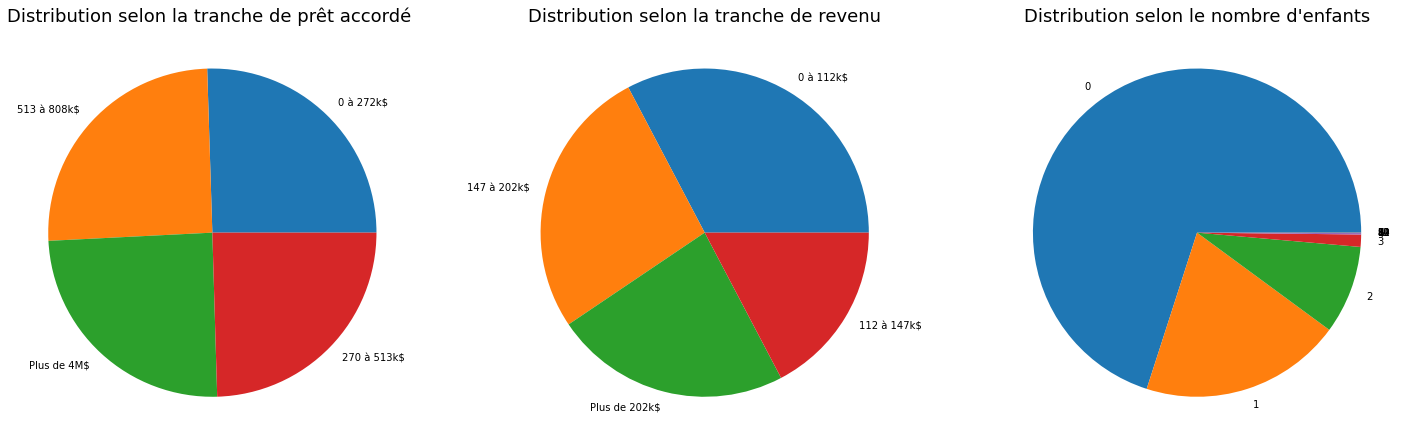

In [38]:
plt.figure(figsize=(25,10))
plt.subplot(1, 3, 1)
my_data = df_application_train['CREDIT_CAT'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon la tranche de prêt accordé ", fontsize=18)

plt.subplot(1, 3, 2)
my_data = df_application_train['INCOME_CAT'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon la tranche de revenu", fontsize=18)

plt.subplot(1, 3, 3)
my_data = df_application_train['CNT_CHILDREN'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon le nombre d'enfants", fontsize=18)
plt.show()

In [39]:
# Distribution selon le prix des biens pour lesquels le prêt est accordé
df_application_train['AMT_GOODS_PRICE'].value_counts()

450000.0     26022
225000.0     25282
675000.0     24962
900000.0     15416
270000.0     11428
             ...  
592452.0         1
1130125.5        1
362632.5         1
498856.5         1
1271875.5        1
Name: AMT_GOODS_PRICE, Length: 1002, dtype: int64

In [40]:
# Distribution selon l'age du client 

# Rendre l'age  positif 
df_application_train['DAYS_BIRTH'] = -1*df_application_train['DAYS_BIRTH']

# Transformer le nombre de jours de l'age en années
df_application_train['DAYS_BIRTH'] = df_application_train['DAYS_BIRTH']/365

# Distribution de l'age en années
df_application_train['DAYS_BIRTH']

0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307506    25.553425
307507    56.917808
307508    41.002740
307509    32.769863
307510    46.180822
Name: DAYS_BIRTH, Length: 307511, dtype: float64

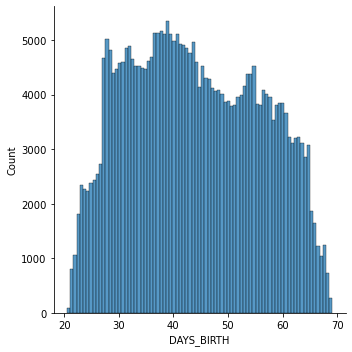

In [41]:
# Visualisation de la distribution de l'age
sns.displot(df_application_train['DAYS_BIRTH'])

In [42]:
# Catégorie selon la tranche d'age
df_application_train['AGE_CAT'] = pd.cut(df_application_train['DAYS_BIRTH'], 
                                         bins=[0,30, 40, 50, 60, 199], 
                                         labels=["Generation Y", "Trentenaire", "Quadra", "Quinqua", "Plus de 60 ans"])
df_application_train['AGE_CAT'].value_counts()

Trentenaire       82308
Quadra            76541
Quinqua           68062
Generation Y      45021
Plus de 60 ans    35579
Name: AGE_CAT, dtype: int64

Text(0.5, 1.0, "Distribution selon la tranche d'age")

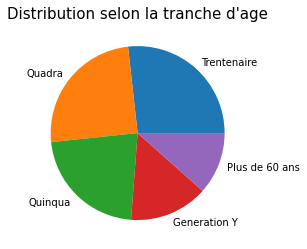

In [43]:
my_data = df_application_train['AGE_CAT'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon la tranche d'age", fontsize=15)

In [44]:
# Distribution selon l'ancienneté au sein du même poste du client en jours

# Transformer l'ancienneté du client en nombre positif 
df_application_train['DAYS_EMPLOYED'] = -1*df_application_train['DAYS_EMPLOYED']

# Transformer le nombre de jours de l'age en années
df_application_train['DAYS_EMPLOYED'] = df_application_train['DAYS_EMPLOYED']/365

# Distribution de l'ancienneté en années
df_application_train['DAYS_EMPLOYED']

0            1.745205
1            3.254795
2            0.616438
3            8.326027
4            8.323288
             ...     
307506       0.646575
307507   -1000.665753
307508      21.701370
307509      13.112329
307510       3.457534
Name: DAYS_EMPLOYED, Length: 307511, dtype: float64

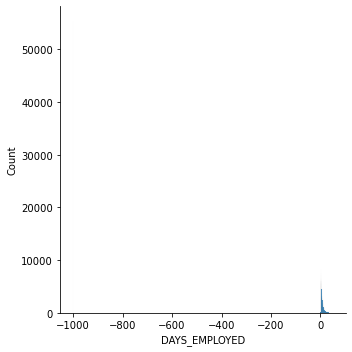

In [45]:
# Visualisation de la distribution du nombre d'employé
sns.displot(df_application_train['DAYS_EMPLOYED'])

On constate qu'un employé à plus de 1000 ans d'ancienneté

In [46]:
# Nombre d'employé ayant un nombre d'années d'ancienneté négatif
x = df_application_train['DAYS_EMPLOYED']<0
x.value_counts()

False    252137
True      55374
Name: DAYS_EMPLOYED, dtype: int64

55374 individus ont une ancienneté négative

In [47]:
# Distribution de l'ancienneté des clients ayant une valeur négative
df_application_train['DAYS_EMPLOYED'][df_application_train['DAYS_EMPLOYED']<0].value_counts()

-1000.665753    55374
Name: DAYS_EMPLOYED, dtype: int64

Ces 55374 individus ont toutes une ancienneté de 1000 ans.
Il s'agit d'une valeure aberrante qu'il faut transformer en nan.

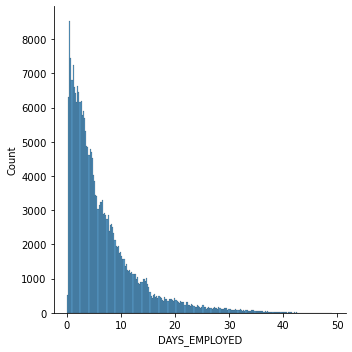

In [48]:
# Transformation en nan des individus ayant une ancienneté négative
df_application_train[df_application_train['DAYS_EMPLOYED']<0] = np.nan

# Vérification qu'il ne reste plus d'individus avec une ancienneté négative
x = df_application_train['DAYS_EMPLOYED']<0
x.value_counts()

# Visualisation de la distribution de l'ancienneté
sns.displot(df_application_train['DAYS_EMPLOYED'])

In [49]:
# Catégorie selon l'ancienneté
df_application_train['ANCIENNETE_CAT'] = pd.cut(df_application_train['DAYS_EMPLOYED'], 
                                         bins=[0, 1, 3, 5, 10, 25, 100], 
                                         labels=["- de 1 ans", "1 à 3ans", "3 à 5 ans", "5 à 10 ans", "10 à 25 ans", 
                                                 "+ de 25 ans"])
df_application_train['ANCIENNETE_CAT'].value_counts()

5 à 10 ans     64872
1 à 3ans       61472
3 à 5 ans      46857
10 à 25 ans    44641
- de 1 ans     27980
+ de 25 ans     6313
Name: ANCIENNETE_CAT, dtype: int64

Text(0.5, 1.0, "Distribution selon l'ancienneté")

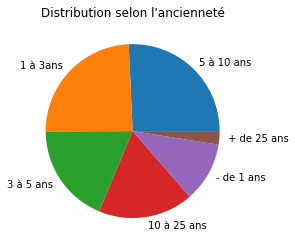

In [50]:
my_data = df_application_train['ANCIENNETE_CAT'].value_counts()
plt.pie(my_data, labels=my_data.index)
plt.title("Distribution selon l'ancienneté")

In [51]:
# Répartition selon le nombre d'observations de l'environnement social du client ayant 30 jours de retard
df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0      134058
1.0       40343
2.0       24614
3.0       16763
4.0       11642
          ...  
26.0          2
30.0          2
348.0         1
47.0          1
29.0          1
Name: OBS_30_CNT_SOCIAL_CIRCLE, Length: 32, dtype: int64

<AxesSubplot:xlabel='OBS_30_CNT_SOCIAL_CIRCLE', ylabel='count'>

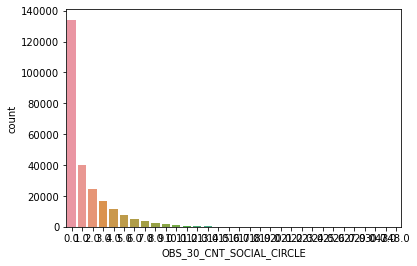

In [52]:
sns.countplot(df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'])

In [53]:
# Répartition selon le nombre d'observations de l'environnement social du client ayant 30 jours de défauts de paiement
df_application_train['DEF_30_CNT_SOCIAL_CIRCLE'].value_counts()

0.0     223101
1.0      22741
2.0       4262
3.0        935
4.0        190
5.0         47
6.0         10
8.0          1
34.0         1
Name: DEF_30_CNT_SOCIAL_CIRCLE, dtype: int64

<AxesSubplot:xlabel='DEF_30_CNT_SOCIAL_CIRCLE', ylabel='count'>

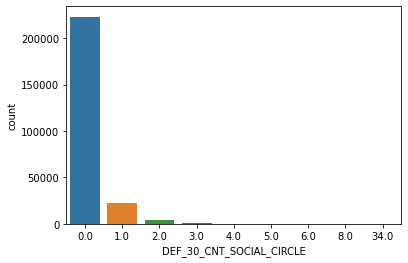

In [54]:
sns.countplot(df_application_train['DEF_30_CNT_SOCIAL_CIRCLE'])

In [55]:
# Distribution du délai en jours entre la demande de prêt du client et son dernier changement de téléphone

# Transformer le délai en nombre positif 
# df_application_train['DAYS_LAST_PHONE_CHANGED'] = -1*df_application_train['DAYS_LAST_PHONE_CHANGE']

# Distribution du délai
df_application_train['DAYS_LAST_PHONE_CHANGE'].value_counts()

 0.0       28889
-1.0        2372
-2.0        1789
-3.0        1467
-4.0        1166
           ...  
-3807.0        1
-3533.0        1
-3683.0        1
-4079.0        1
-3963.0        1
Name: DAYS_LAST_PHONE_CHANGE, Length: 3744, dtype: int64

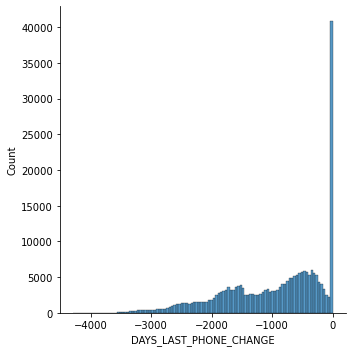

In [56]:
sns.displot(df_application_train['DAYS_LAST_PHONE_CHANGE'])

In [57]:
df_application_train['DAYS_LAST_PHONE_CHANGE'].value_counts().sort_values()

-3963.0        1
-3680.0        1
-3857.0        1
-3845.0        1
-3699.0        1
           ...  
-4.0        1166
-3.0        1467
-2.0        1789
-1.0        2372
 0.0       28889
Name: DAYS_LAST_PHONE_CHANGE, Length: 3744, dtype: int64

Selon le df, 28889 clients on changé de téléphone le jour de leur demande de pret
C'est une valeure aberrante qu'il faut transformer en nan.

In [58]:
# Transformation en nan
df_application_train[df_application_train['DAYS_LAST_PHONE_CHANGE']==0] = np.nan

In [59]:
df_application_train['DAYS_LAST_PHONE_CHANGE'].value_counts().sort_values()

-4079.0       1
-3783.0       1
-3570.0       1
-3926.0       1
-3505.0       1
           ... 
-5.0        771
-4.0       1166
-3.0       1467
-2.0       1789
-1.0       2372
Name: DAYS_LAST_PHONE_CHANGE, Length: 3743, dtype: int64

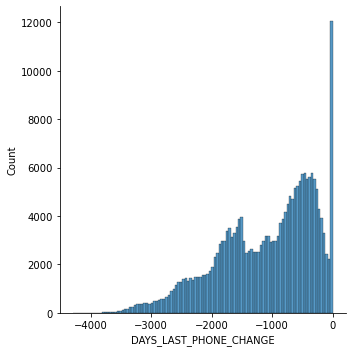

In [60]:
sns.displot(df_application_train['DAYS_LAST_PHONE_CHANGE'])

In [61]:
# Distribution du délai en jours entre la demande de prêt du client et son dernier changement de document d'identité

# Transformer le délai en nombre positif 
df_application_train['DAYS_ID_PUBLISH'] = -1*df_application_train['DAYS_ID_PUBLISH']

# Distribution du délai
df_application_train['DAYS_ID_PUBLISH'].value_counts()

4032.0    105
4166.0    102
4081.0    101
4270.0     99
4256.0     99
         ... 
5810.0      1
5982.0      1
6211.0      1
6128.0      1
6029.0      1
Name: DAYS_ID_PUBLISH, Length: 6125, dtype: int64

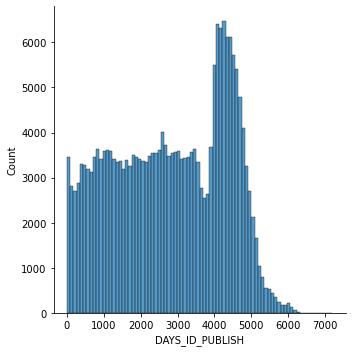

In [62]:
sns.displot(df_application_train['DAYS_ID_PUBLISH'])

In [63]:
# Répartition selon le nombre de demandes de renseignements par le client un jour avant sa demande demande de crédit
df_application_train['AMT_REQ_CREDIT_BUREAU_DAY'].value_counts()

0.0    192874
1.0       921
2.0        76
3.0        41
4.0        20
5.0         8
6.0         7
9.0         2
Name: AMT_REQ_CREDIT_BUREAU_DAY, dtype: int64

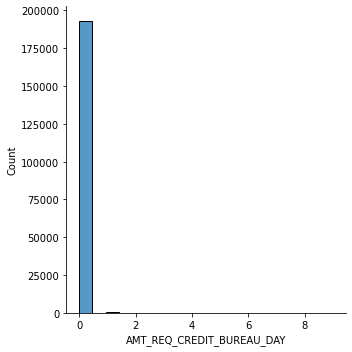

In [64]:
sns.displot(df_application_train['AMT_REQ_CREDIT_BUREAU_DAY'])

In [65]:
# Création d'un df contenant les variables quantitatives
df_app_train_quant = df_application_train.loc[:, ['TARGET','AMT_INCOME_TOTAL', 'AMT_CREDIT' ,'AMT_ANNUITY','AMT_GOODS_PRICE',
                                                  'REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED',
                                                 'AMT_REQ_CREDIT_BUREAU_DAY','DAYS_LAST_PHONE_CHANGE','DAYS_ID_PUBLISH',
                                                  'OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE']]
df_app_train_quant.describe()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,AMT_REQ_CREDIT_BUREAU_DAY,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE
count,223248.000000,2.232480e+05,2.232480e+05,223236.000000,2.230040e+05,223248.000000,223248.000000,223248.000000,193949.000000,223247.000000,223248.000000,222454.000000,222454.000000
mean,0.083992,1.765897e+05,6.166180e+05,27857.669690,5.551749e+05,0.020950,40.543419,6.584893,0.007095,-1096.694634,2799.070648,1.407406,0.139184
std,0.277376,1.158777e+05,4.099653e+05,14712.955279,3.769443e+05,0.013962,10.008367,6.405581,0.113948,796.991767,1516.251393,2.398571,0.440927
min,0.000000,2.655000e+04,4.500000e+04,1980.000000,4.050000e+04,0.000290,20.517808,0.000000,0.000000,-4292.000000,-0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.814930e+05,17095.500000,2.475000e+05,0.010006,32.383562,2.150685,0.000000,-1664.000000,1482.000000,0.000000,0.000000
50%,0.000000,1.575000e+05,5.212800e+05,25839.000000,4.500000e+05,0.018850,40.041096,4.572603,0.000000,-917.000000,2883.000000,0.000000,0.000000
75%,0.000000,2.160000e+05,8.353800e+05,35680.500000,7.020000e+05,0.028663,48.175342,8.767123,0.000000,-443.000000,4176.000000,2.000000,0.000000
max,1.000000,1.800009e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,69.041096,49.073973,9.000000,-1.000000,7197.000000,348.000000,34.000000


In [66]:
# Création d'un df contenant les variables qualitatives
df_app_train_quali = df_application_train.loc[:, ['TARGET','NAME_CONTRACT_TYPE', 'CODE_GENDER', 'CNT_CHILDREN', 'FLAG_OWN_CAR', 
                                                  'FLAG_OWN_REALTY','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                                                  'REGION_RATING_CLIENT','FLAG_CONT_MOBILE','NAME_INCOME_TYPE',
                                                  'NAME_EDUCATION_TYPE','OCCUPATION_TYPE']]
df_app_train_quali

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_RATING_CLIENT,FLAG_CONT_MOBILE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,OCCUPATION_TYPE
0,1.0,Cash loans,M,0.0,N,Y,Single / not married,House / apartment,2.0,1.0,Working,Secondary / secondary special,Laborers
1,0.0,Cash loans,F,0.0,N,N,Married,House / apartment,1.0,1.0,State servant,Higher education,Core staff
2,0.0,Revolving loans,M,0.0,Y,Y,Single / not married,House / apartment,2.0,1.0,Working,Secondary / secondary special,Laborers
3,0.0,Cash loans,F,0.0,N,Y,Civil marriage,House / apartment,2.0,1.0,Working,Secondary / secondary special,Laborers
4,0.0,Cash loans,M,0.0,N,Y,Single / not married,House / apartment,2.0,1.0,Working,Secondary / secondary special,Core staff
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,Cash loans,M,0.0,N,N,Separated,With parents,1.0,1.0,Working,Secondary / secondary special,Sales staff
307507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,0.0,Cash loans,F,0.0,N,Y,Separated,House / apartment,3.0,1.0,Working,Higher education,Managers
307509,1.0,Cash loans,F,0.0,N,Y,Married,House / apartment,2.0,1.0,Commercial associate,Secondary / secondary special,Laborers


# 1.2 Analyse multivariés

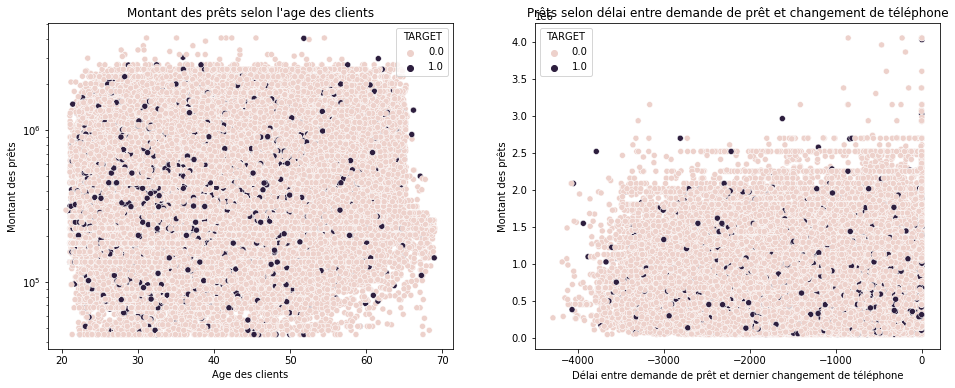

In [67]:
# Distribution du montant des crédits, selon les 2 variables quantitatives distribuées 'normalement' 

plt.figure(figsize=(16,6))

# Montant des prêts selon l'age du client 
plt.subplot(1, 2, 1)
y = df_application_train['AMT_CREDIT']
x = df_application_train['DAYS_BIRTH']
z = df_application_train['TARGET']

sns.scatterplot(x, y, hue=z)
plt.yscale("log")
plt.title("Montant des prêts selon l'age des clients")
plt.xlabel('Age des clients', fontsize=10)
plt.ylabel('Montant des prêts', fontsize=10)
plt.xticks(fontsize=10)


# Montant des prêts selon le délai entre sa demande de pret et son dernier changement de numéro de téléphone 
plt.subplot(1, 2, 2)
y = df_application_train['AMT_CREDIT']
x = df_application_train['DAYS_LAST_PHONE_CHANGE']
z = df_application_train['TARGET']

sns.scatterplot(x, y, hue=z)
plt.title("Prêts selon délai entre demande de prêt et changement de téléphone")
plt.xlabel('Délai entre demande de prêt et dernier changement de téléphone', fontsize=10)
plt.ylabel('Montant des prêts', fontsize=10)
plt.xticks(fontsize=10)

plt.show()

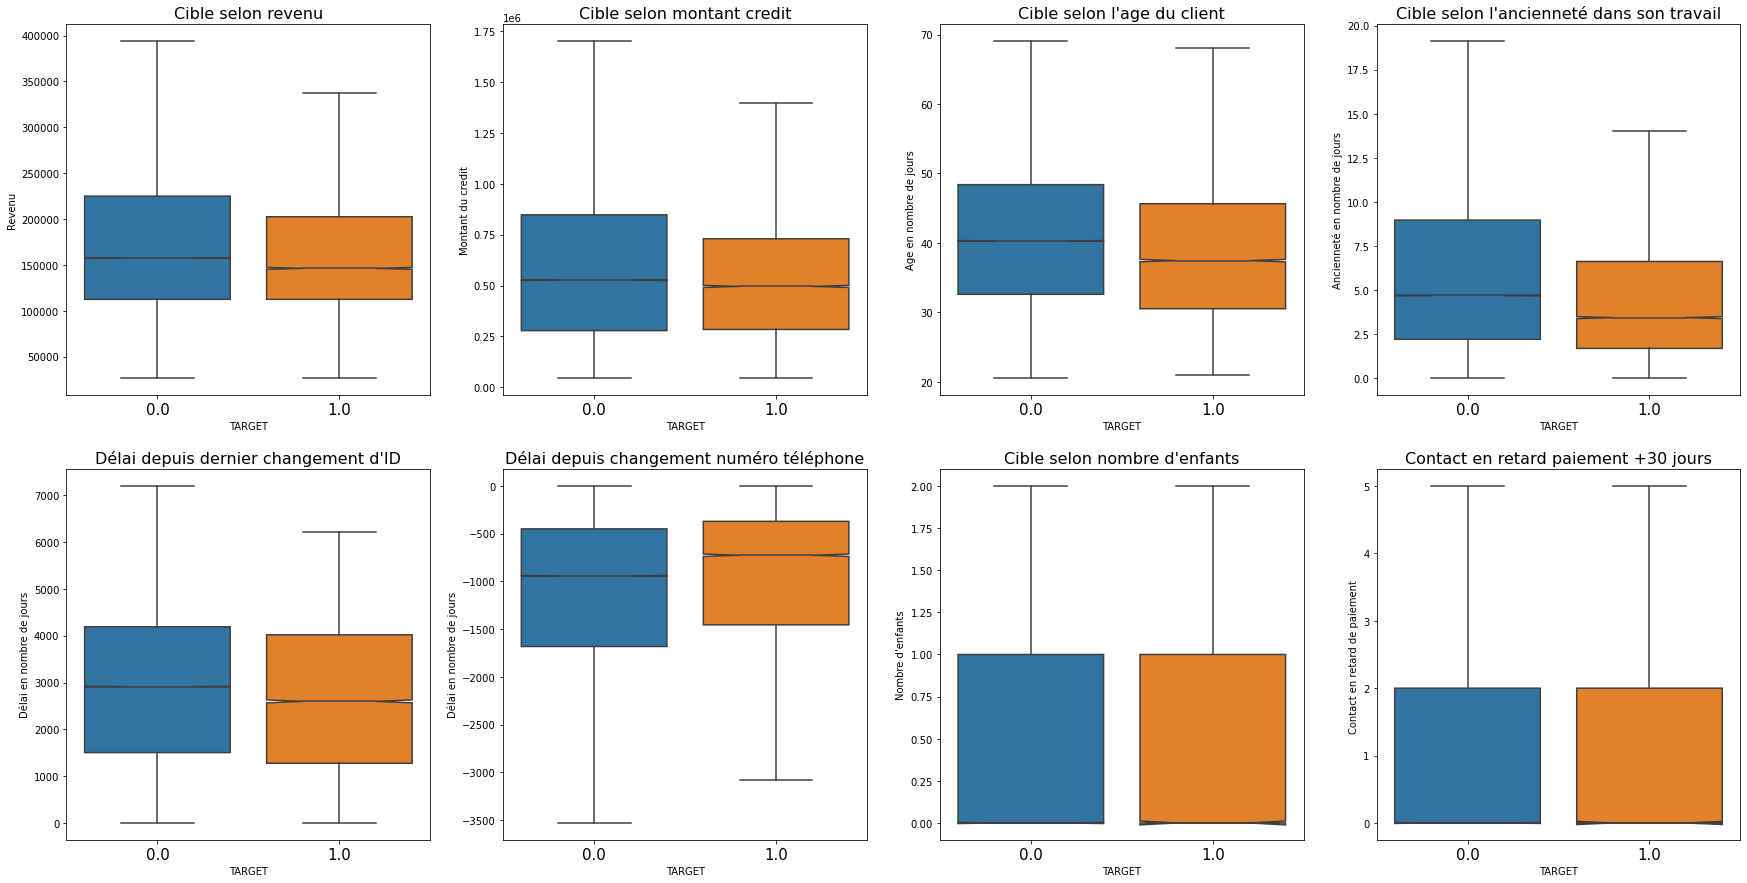

In [68]:
# Distribution des variables quantitatives selon la target
plt.figure(figsize=(30,15))

# Répartition de la variable cible selon le revenu (sans les valeures extrêmes)
plt.subplot(2, 4, 1)
sns.boxplot(df_application_train['TARGET'], df_application_train['AMT_INCOME_TOTAL'], notch=True , showfliers=False)
plt.title("Cible selon revenu", fontsize=16)
plt.ylabel("Revenu")
plt.xticks(fontsize=15)

#  Répartition de la variable cible selon le montant du credit
plt.subplot(2, 4, 2)
sns.boxplot(df_application_train['TARGET'], df_application_train['AMT_CREDIT'], notch=True , showfliers=False)
plt.title("Cible selon montant credit", fontsize=16)
plt.ylabel("Montant du credit")
plt.xticks(fontsize=15)

#  Répartition de la variable cible selon l'age du client
plt.subplot(2, 4, 3)
sns.boxplot(df_application_train['TARGET'], df_application_train['DAYS_BIRTH'], notch=True , showfliers=False)
plt.title("Cible selon l'age du client", fontsize=16)
plt.ylabel("Age en nombre de jours")
plt.xticks(fontsize=15)

#  Répartition de la variable cible selon l'ancienneté du client dans son travail(en nombre de jours )
plt.subplot(2, 4, 4)
sns.boxplot(df_application_train['TARGET'], df_application_train['DAYS_EMPLOYED'], notch=True , showfliers=False)
plt.title("Cible selon l'ancienneté dans son travail", fontsize=16)
plt.ylabel("Ancienneté en nombre de jours")
plt.xticks(fontsize=15)

#  Répartition de la cible selon le délai entre sa demande de prêt et son dernier changement de documents d'identités
plt.subplot(2, 4, 5)
sns.boxplot(df_application_train['TARGET'], df_application_train['DAYS_ID_PUBLISH'], notch=True , showfliers=False)
plt.title("Délai depuis dernier changement d'ID", fontsize=16)
plt.ylabel("Délai en nombre de jours")
plt.xticks(fontsize=15)

#  Répartition de la variable cible selon selon le délai entre sa demande de prêt et son dernier changement de téléphone
plt.subplot(2, 4, 6)
sns.boxplot(df_application_train['TARGET'], df_application_train['DAYS_LAST_PHONE_CHANGE'], notch=True , showfliers=False)
plt.title("Délai depuis changement numéro téléphone", fontsize=16)
plt.ylabel("Délai en nombre de jours")
plt.xticks(fontsize=15)

# Répartition de la variable cible selon le nombre d'enfants
plt.subplot(2, 4, 7)
sns.boxplot(df_application_train['TARGET'], df_application_train['CNT_CHILDREN'], notch=True, showfliers=False)
plt.title("Cible selon nombre d'enfants", fontsize=16)
plt.ylabel("Nombre d'enfants")
plt.xticks(fontsize=15)

# Répartition de la variable cible selon le nombre de contact en défaut de paiement depuis au moins 30jours
plt.subplot(2, 4, 8)
sns.boxplot(df_application_train['TARGET'], df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'],notch=True, showfliers=False)
plt.title("Contact en retard paiement +30 jours", fontsize=16)
plt.ylabel("Contact en retard de paiement ")
plt.xticks(fontsize=15)

plt.show()

Il semble que :

- les clients ayant des difficultés de paiement (1) ont des revenus médians moins importants.


- les clients ayant des difficultés de paiement ont des emprunts médians similaires, mais que leur emprunt maximal soient moins importants.


- les clients ayant des difficultés de paiement sont globalement plus jeunes.


- les clients ayant des difficultés de paiement ont été embauchés plus récemment.


- les clients ayant des difficultés de paiement ont fait des demandes de documents d'identités plus récentes.


- les clients ayant des difficultés de paiement ont changé de numéro de téléphone plus récemment.


- le nombre d'enfants ne semble pas changer le fait que les clients aient des difficultés de paiement.


- le nombre de contact en retard de paiement ne semble pas changer le fait que les clients aient des difficultés de paiement.

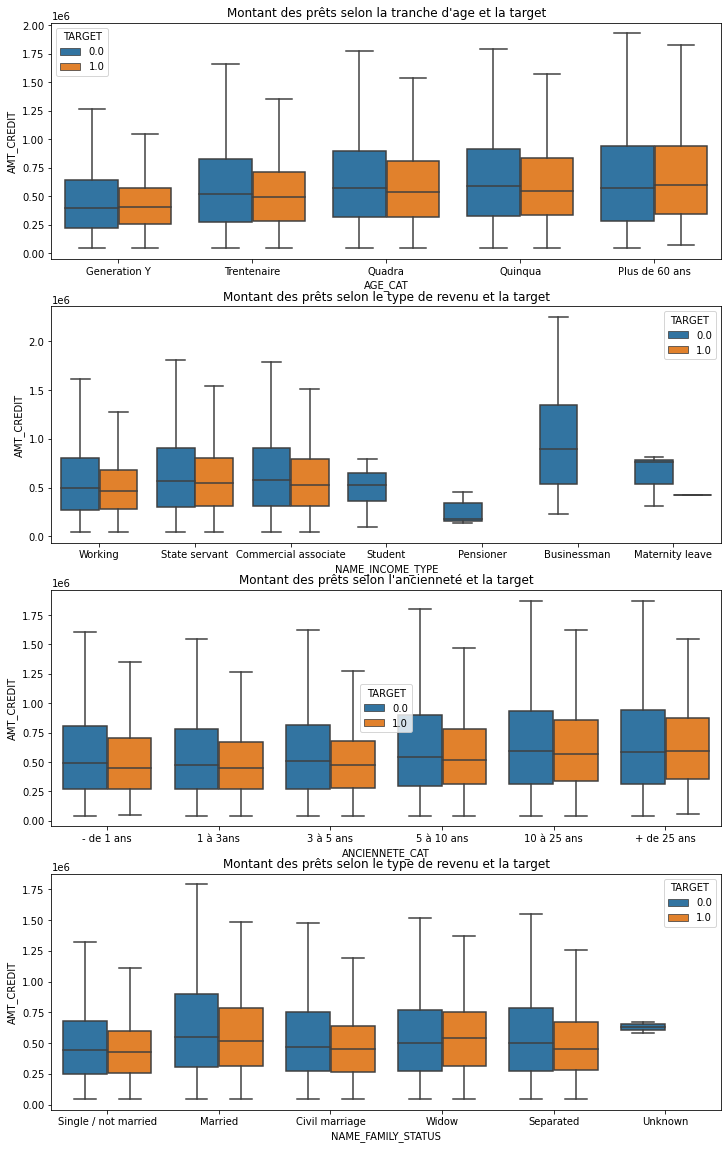

In [69]:
plt.figure(figsize=(12,20))

plt.subplot(4, 1, 1)
sns.boxplot(y="AMT_CREDIT", x="AGE_CAT",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon la tranche d'age et la target")

plt.subplot(4, 1, 2)
sns.boxplot(y="AMT_CREDIT", x="NAME_INCOME_TYPE",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon le type de revenu et la target")

plt.subplot(4, 1, 3)
sns.boxplot(y="AMT_CREDIT", x="ANCIENNETE_CAT",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon l'ancienneté et la target")

plt.subplot(4, 1, 4)
sns.boxplot(y="AMT_CREDIT", x="NAME_FAMILY_STATUS",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon le type de revenu et la target")

plt.show()

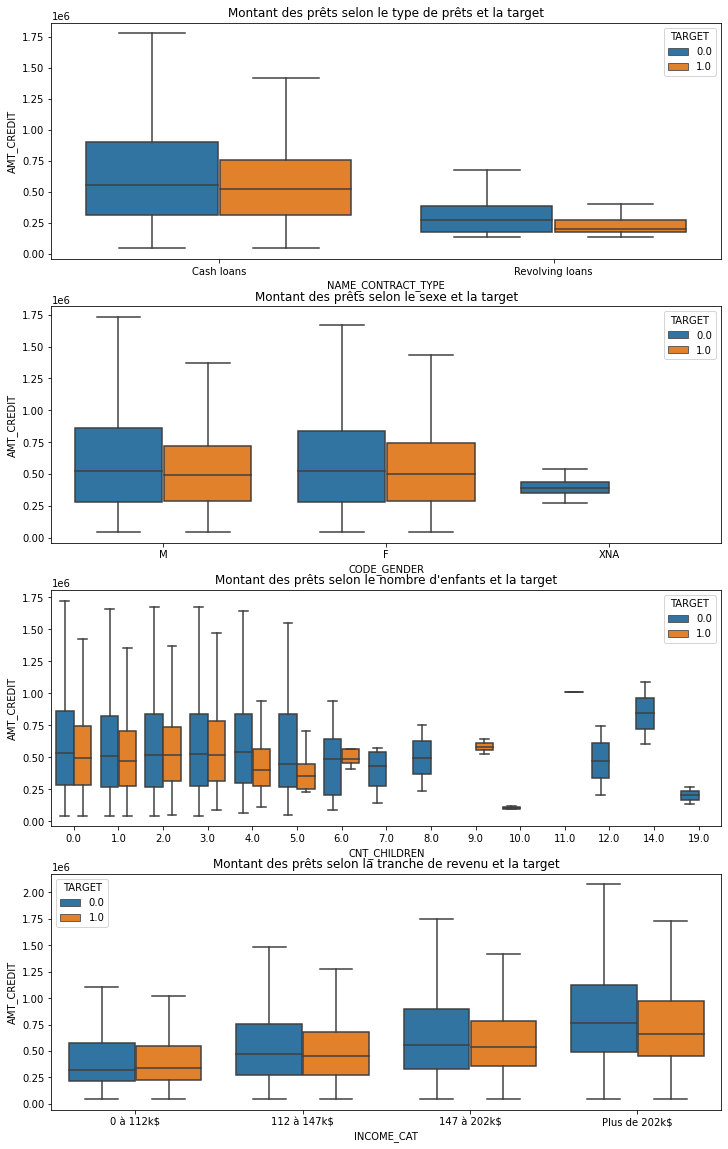

In [70]:
plt.figure(figsize=(12,20))

plt.subplot(4, 1, 1)
sns.boxplot(y="AMT_CREDIT", x="NAME_CONTRACT_TYPE",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon le type de prêts et la target")

plt.subplot(4, 1, 2)
sns.boxplot(y="AMT_CREDIT", x="CODE_GENDER",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon le sexe et la target")

plt.subplot(4, 1, 3)
sns.boxplot(y="AMT_CREDIT", x="CNT_CHILDREN",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon le nombre d'enfants et la target")

plt.subplot(4, 1, 4)
sns.boxplot(y="AMT_CREDIT", x="INCOME_CAT",hue="TARGET",data=df_application_train, showfliers=False)
plt.title("Montant des prêts selon la tranche de revenu et la target")

plt.show()

Il semble que :

- Pour la target, les prêts les plus élevés ne sont pas attribués à des clients ayant des difficultés de paiement.
- Le monant des prêts selon le nombre d'enfants reste stable jusqu'à 5 enfants.
Les fluctuations après ce nombre peuvent être dues aux données moins importantes, ce qu'indique la baisse de l'intervalle de confiance.
- Pour les prêts les plus importatnts sont accordés à des prêts classiques et non à des crédits revolving.
- Les catégories de prêts ne semblent pas mettre en avant de différences flagrantes entre les individus.
- Le montant des prêts est similaire pour les hommes et les femmes le sexe.
L'intervalle de confiance est plus faible dans la 3e catégorie pour en tirer des conclusions ou émettre des hypothèses.
- Les personnes mariés obtiennent les prêts les plus élevés.
- Les businessmen obtiennent les prêts les plus élevés et les retraités les plus bas.

Text(0.5, 1.0, "Montant des prêts selon tranche d'age e target")

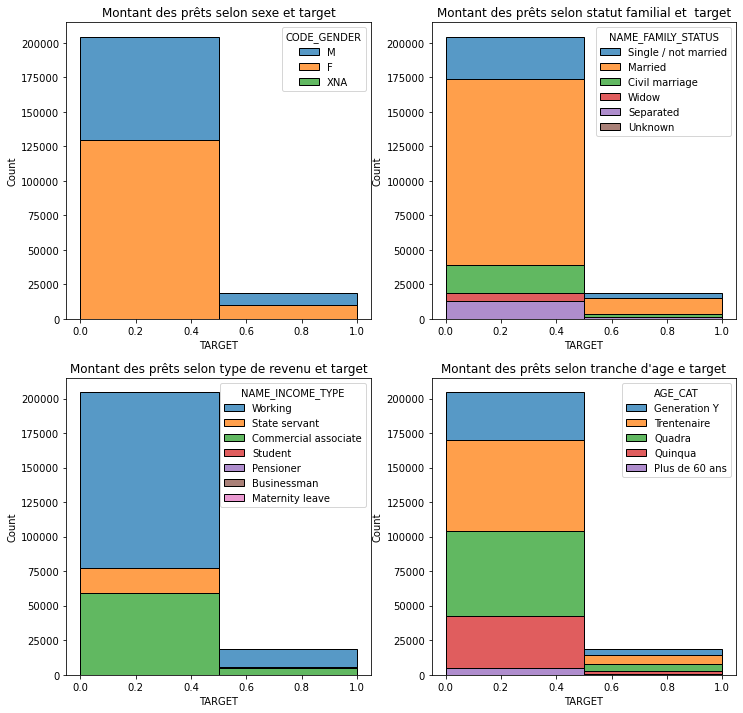

In [71]:
# Distribution du montant des prêts selon différentes variables qualitatives 
plt.figure(figsize=(12,12))
df = df_application_train

# Montant des prêts selon la variable cible (sans les valeures extrêmes)
plt.subplot(2, 2, 1)
sns.histplot(binwidth=0.5, x="TARGET", hue="CODE_GENDER", data=df, stat="count", multiple="stack")
plt.title("Montant des prêts selon sexe et target")

plt.subplot(2, 2, 2)
sns.histplot(binwidth=0.5, x="TARGET", hue="NAME_FAMILY_STATUS", data=df, stat="count", multiple="stack")
plt.title("Montant des prêts selon statut familial et  target")

plt.subplot(2, 2, 3)
sns.histplot(binwidth=0.5, x="TARGET", hue="NAME_INCOME_TYPE", data=df, stat="count", multiple="stack")
plt.title("Montant des prêts selon type de revenu et target")

plt.subplot(2, 2, 4)
sns.histplot(binwidth=0.5, x="TARGET", hue="AGE_CAT", data=df, stat="count", multiple="stack")
plt.title("Montant des prêts selon tranche d'age e target")


# 2. FEATURES CREATION

- Il est plus grave pour une banque de prêter de l'argent à une personne qui ne remboursera pas le prêt, que de ne pas prêter à une personne qui aurait pu le rembourser.
- Il est donc important de surtout minimiser le taux de faux négatif, ainsi que de maximiser le taux de vrai positif.
- Nous allons donc concentrer notre création de features sur les clients à éviter.

In [72]:
# Features bancaires

# Prêts en % des revenus
df_application_train['INCOME_CREDIT_PERC'] = df_application_train['AMT_INCOME_TOTAL'] / df_application_train['AMT_CREDIT']

# Revenus divisé par le nombre de personnes au sein du foyer
df_application_train['INCOME_PERSON'] = df_application_train['AMT_INCOME_TOTAL'] / df_application_train['CNT_FAM_MEMBERS']

# Taux d'endetement
df_application_train['PAYMENT_RATE'] = df_application_train['AMT_ANNUITY'] / df_application_train['AMT_CREDIT']


# Reste à vivre
df_application_train['REMAIN_TO_LIVE'] = df_application_train['AMT_INCOME_TOTAL'] - df_application_train['AMT_ANNUITY']

# Reste à vivre en pourcentage du revenu
df_application_train['REMAIN_TO_LIVE_P'] = df_application_train['REMAIN_TO_LIVE']/df_application_train['AMT_INCOME_TOTAL']

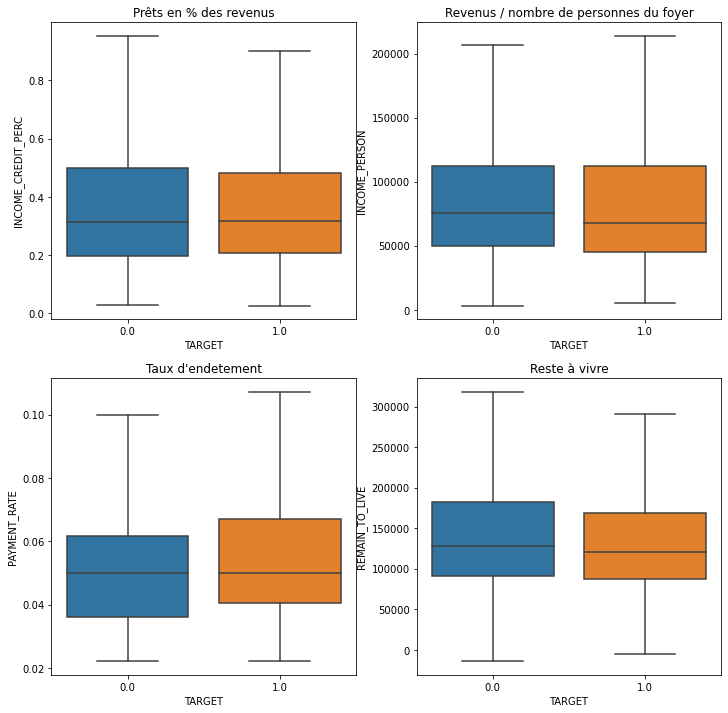

In [73]:
plt.figure(figsize=(12,12))

plt.subplot(2, 2, 1)
sns.boxplot(data = df_application_train, y = 'INCOME_CREDIT_PERC', x = 'TARGET', showfliers=False)
plt.title('Prêts en % des revenus')

plt.subplot(2, 2, 2)
sns.boxplot(data = df_application_train, y = 'INCOME_PERSON', x = 'TARGET', showfliers=False)
plt.title('Revenus / nombre de personnes du foyer')

plt.subplot(2, 2, 3)
sns.boxplot(data = df_application_train, y = 'PAYMENT_RATE', x = 'TARGET', showfliers=False)
plt.title("Taux d'endetement")

plt.subplot(2, 2, 4)
sns.boxplot(data = df_application_train, y = 'REMAIN_TO_LIVE', x = 'TARGET', showfliers=False)
plt.title('Reste à vivre')

plt.show()

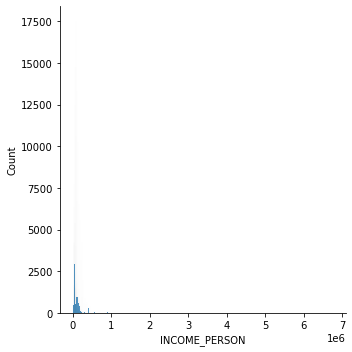

In [74]:
sns.displot(df_application_train['INCOME_PERSON'])

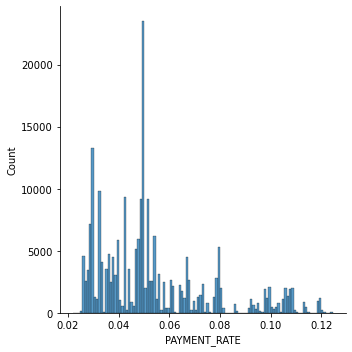

In [75]:
sns.displot(df_application_train['PAYMENT_RATE'])

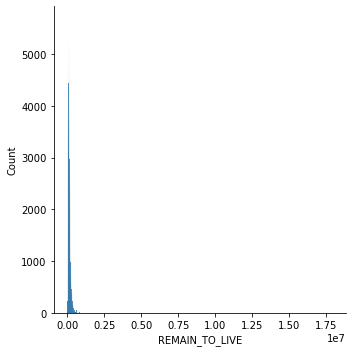

In [76]:
sns.displot(df_application_train['REMAIN_TO_LIVE'])

In [77]:
df_application_train['INCOME_CREDIT_PERC'].describe()

count    223248.000000
mean          0.406690
std           0.351499
min           0.027254
25%           0.198675
50%           0.313185
75%           0.500000
max          26.666800
Name: INCOME_CREDIT_PERC, dtype: float64

In [78]:
# Catégorie selon la valeur du prêts en % des revenus
df_application_train['INC_CRED_PERC_CAT'] = pd.cut(df_application_train['INCOME_CREDIT_PERC'], 
                                         bins=[0, 0.193803, 0.306272, 0.495376, 208.003328], 
                                          labels=["- 25p", "-50p", "-75p", "+75p"])
df_application_train['INC_CRED_PERC_CAT'].value_counts()

+75p     57774
-75p     56205
-50p     55651
- 25p    53618
Name: INC_CRED_PERC_CAT, dtype: int64

In [79]:
df_application_train['INCOME_PERSON'].describe()

count    2.232460e+05
mean     9.421914e+04
std      7.651273e+04
min      3.375000e+03
25%      4.800000e+04
50%      7.500000e+04
75%      1.125000e+05
max      6.750000e+06
Name: INCOME_PERSON, dtype: float64

In [80]:
# Catégorie selon les revenus divisé par le nombre de personnes au sein du foyer
df_application_train['INCOME_PERSON_CAT'] = pd.cut(df_application_train['INCOME_PERSON'], 
                                          bins=[0, 4.725000e+04, 7.500000e+04, 1.125000e+05, 3.900000e+07], 
                                          labels=["- 25p", "-50p", "-75p", "+75p"])
df_application_train['INCOME_PERSON_CAT'].value_counts()

-75p     57819
-50p     56624
- 25p    55541
+75p     53262
Name: INCOME_PERSON_CAT, dtype: int64

In [81]:
df_application_train['PAYMENT_RATE'].describe()

count    223236.000000
mean          0.053537
std           0.022435
min           0.022073
25%           0.036377
50%           0.050000
75%           0.063910
max           0.124430
Name: PAYMENT_RATE, dtype: float64

In [82]:
# Catégorie selon le taux d'endetement
df_application_train['PAYMENT_RATE_CAT'] = pd.cut(df_application_train['PAYMENT_RATE'], 
                                         bins=[0, 0.036900, 0.050000, 0.064043, 0.124430], 
                                         labels=["- 25p", "-50p", "-75p", "+75p"])
df_application_train['PAYMENT_RATE_CAT'].value_counts()

-50p     75439
- 25p    56270
+75p     55691
-75p     35836
Name: PAYMENT_RATE_CAT, dtype: int64

In [83]:
df_application_train['REMAIN_TO_LIVE'].describe()

count    2.232360e+05
mean     1.487315e+05
std      1.108544e+05
min     -1.422450e+04
25%      9.115650e+04
50%      1.270845e+05
75%      1.808910e+05
max      1.793079e+07
Name: REMAIN_TO_LIVE, dtype: float64

In [84]:
# Catégorie selon le reste à vivre
df_application_train['REMAIN_TO_LIVE_CAT'] = pd.cut(df_application_train['REMAIN_TO_LIVE'], 
                                         bins=[0, 8.544150e+04, 1.210770e+05, 1.732500e+05, 1.169738e+08], 
                                          labels=["- 25p", "-50p", "-75p", "+75p"])
df_application_train['REMAIN_TO_LIVE_CAT'].value_counts()

+75p     61726
-75p     58848
-50p     55181
- 25p    47469
Name: REMAIN_TO_LIVE_CAT, dtype: int64

In [85]:
df_application_train['REMAIN_TO_LIVE_P'].describe()

count    223236.000000
mean          0.823377
std           0.091055
min          -0.451571
25%           0.776133
50%           0.840629
75%           0.887915
max           0.996667
Name: REMAIN_TO_LIVE_P, dtype: float64

In [86]:
# Catégorie selon le reste à vivre en pourcentage du revenu
df_application_train['REMAIN_TO_LIVE_P_CAT'] = pd.cut(df_application_train['REMAIN_TO_LIVE_P'], 
                                         bins=[0, 0.770933, 0.837167, 0.885218, 0.999776], 
                                        labels=["- 25p", "-50p", "-75p", "+75p"])
df_application_train['REMAIN_TO_LIVE_P_CAT'].value_counts()

+75p     58479
-75p     56878
-50p     55340
- 25p    52527
Name: REMAIN_TO_LIVE_P_CAT, dtype: int64

In [87]:
# Features économiques et sociales

# Hauts Revenus
df_application_train['HIGH_INCOME'] = np.where((df_application_train['AMT_INCOME_TOTAL'] > 2.025000e+05), 1, 0) 
# Bas revenus
df_application_train['LOW_INCOME'] = np.where((df_application_train['AMT_INCOME_TOTAL'] < 1.125000e+05), 1, 0) 


# Prêts importants
df_application_train['HIGH_CREDIT'] = np.where((df_application_train['AMT_CREDIT'] > 8.086500e+05), 1, 0) 
# Prêts bas 
df_application_train['LOW_CREDIT'] = np.where((df_application_train['AMT_CREDIT'] < 2.700000e+05), 1, 0) 

# Voitures récentes
df_application_train['NEW_CAR'] = np.where((df_application_train['OWN_CAR_AGE'] < 5), 1, 0) 
# Voitures anciennes
df_application_train['OLD_CAR'] = np.where((df_application_train['OWN_CAR_AGE'] > 15), 1, 0) 

# Personne plus agé
df_application_train['MATURE_PEOPLE'] = np.where((df_application_train['DAYS_BIRTH'] >48), 1, 0)
# Personne jeune
df_application_train['YOUNG_PEOPLE'] = np.where((df_application_train['DAYS_BIRTH'] <32), 1, 0) 
 
# Embauche ancienne 
df_application_train['OLD_HIRING'] = np.where((df_application_train['DAYS_EMPLOYED'] >8.76), 1, 0) 
# Embauche récente
df_application_train['RECENT_HIRING'] = np.where((df_application_train['DAYS_EMPLOYED'] <2.15), 1, 0) 

# >= 1 Contact avec un retard de paiement de 30 jours
df_application_train['DELAY_30'] = np.where((df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'] >= 1), 1, 0) 
# >= 1 Contact avec un defaut de paiement de 30 jours
df_application_train['DEFAUT_30'] = np.where((df_application_train['DEF_30_CNT_SOCIAL_CIRCLE'] >= 1), 1, 0)

df.shape

(307511, 148)

# Corrélation des variables quantitatives

<AxesSubplot:>

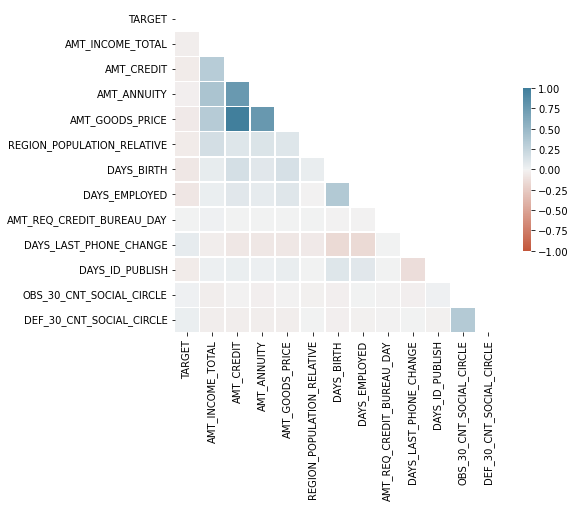

In [88]:
# Heatmap de correlation 

# calculer la matrice de corrélation
corr = df_app_train_quant.corr()

# mask pour cacher le triangle du haut
mask = np.triu(np.ones_like(corr, dtype=bool))

# configurer la figure matplotlib
f, ax = plt.subplots(figsize=(8,6))

# générer une heatmap avec des couleurs divergentes personnalisées
cmap = sns.diverging_palette(20, 230, as_cmap=True)

# dessiner la heatmap avec le mask et les bons ratios d'aspects
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Il semble que : 

- le montant des crédits et des traites soit corrélés
- le montant des crédits et des biens achetés avec les prêts soit très corrélés
- le montant des traites et des biens achetés avec les prêts soit corrélés
- l'ancienneté du client et son age soit négativement corrélés
- l'environnement social du client avec 30 jours de défaut de paiement et celui avec 30 jours de defauts de paiement soit légèrement corrélés.
-le délai entre la demande de prêt et la dernière demande de documents d'identité soit légèrement corrélé avec l'âge.
- le délai entre la demande de prêt et la dernière demande de documents d'identité soit légèrement négativement corrélé avec l'ancienneté.

In [89]:
#sns.pairplot(df_app_train_quant, corner=True)

Il semble que :

 - le montant des crédits et des traites soit corrélés de façon linéaire.
 - le montant des crédits et des biens achetés avec les prêts soit très corrélés de manière linéaire.
 - le montant des traites et des biens achetés avec les prêts soit corrélés de façon linéaire.
 - le nombre de jour d'emploi et le nombre de jour de naissance soit négativement corrélés et ne le soit pas de façon linéaire.

# 3. ANALYSE STATISTIQUE

# Tests statistiques

Nous allons effectuer des tests statistiques pour vérifier si nos hypothèses sont vraies ou fausses.
Nous utiliseorns des tests paramétriques pour leurs puissances :

- Corrélation de Pearsons
- ANOVA
- Chi-2

## Corrélation de Pearsons
... entre le montant des crédits et la valeur des biens achetés avec les prêts (pour vérifier si les clients dépensent bien le prêt dans le bien initialement déclaré)

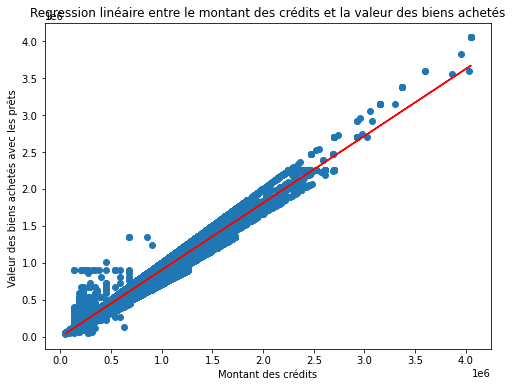

La pente de la regression est : 0.9070418907953144
La p_value est : 0.0


In [90]:
# Regression linéaire entre le montant des crédits et la valeur des biens achetés avec les prêts 

# Création d'un df pour la regression
df_quant_reg = df_app_train_quant[['AMT_CREDIT', 'AMT_GOODS_PRICE']]
df_quant_reg = df_quant_reg.dropna()

x = df_quant_reg['AMT_CREDIT']
y = df_quant_reg['AMT_GOODS_PRICE']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Création de la fonction prédict
def predict(x, slope, intercept):
    return slope*x+intercept

# Visualisation de la regression linéaire
plt.figure(figsize=(8,6))

fitline = predict(x, slope, intercept)
plt.scatter(x, y)
plt.plot(x, fitline, c='r')

plt.title('Regression linéaire entre le montant des crédits et la valeur des biens achetés')
plt.xlabel('Montant des crédits')
plt.ylabel('Valeur des biens achetés avec les prêts ')

plt.show()

#Affichage des scores de la pente et de la p_value
print("La pente de la regression est :", slope)
print("La p_value est :", p_value)

In [91]:
# Corrélation de Pearson

df_co = df_application_train[['AMT_CREDIT', 'AMT_GOODS_PRICE']]
df_co.corr(method='pearson')

,AMT_CREDIT,AMT_GOODS_PRICE
AMT_CREDIT,1.00000,0.98656
AMT_GOODS_PRICE,0.98656,1.00000


La p_value est statistiquement significative (p <0.05). Nous concluons que le montant des crédits est corrélé linéairement avec les biens achetés, cette dernière feature pourra donc être retiré du df.

In [92]:
df_application_train = df_application_train.drop(['AMT_GOODS_PRICE'], axis=1)

## Corrélation de Pearsons
... entre le montant des crédits et l'âge des clients (pour vérifier si le montant des crédits augmente ou diminue linéairement en fonction de l'âge)

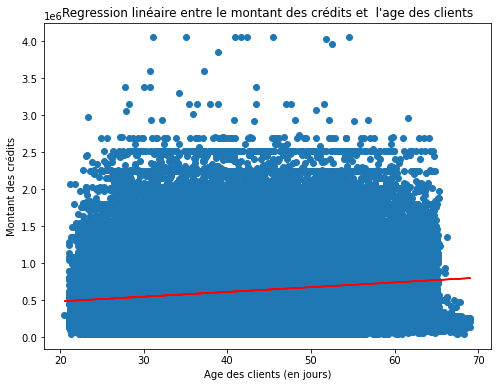

La pente de la regression est : 6412.387147237174
La p_value est : 0.0


In [93]:
# Benchmark : Regression linéaire entre le montant des crédits et l'age des clients'

# Création d'un df pour la regression
df_quant_reg = df_app_train_quant[['AMT_CREDIT', 'DAYS_BIRTH']]
df_quant_reg = df_quant_reg.dropna()

y = df_quant_reg['AMT_CREDIT']
x = df_quant_reg['DAYS_BIRTH']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Création de la fonction prédict
def predict(x, slope, intercept):
    return slope*x+intercept

# Visualisation de la regression linéaire
plt.figure(figsize=(8,6))

fitline = predict(x, slope, intercept)
plt.scatter(x, y)
plt.plot(x, fitline, c='r')

plt.title("Regression linéaire entre le montant des crédits et  l'age des clients")
plt.ylabel('Montant des crédits')
plt.xlabel('Age des clients (en jours)')

plt.show()

#Affichage des scores de la pente et de la p_value
print("La pente de la regression est :", slope)
print("La p_value est :", p_value)

In [94]:
# Corrélation de Pearson

df_co2 = df_application_train[['AMT_CREDIT', 'DAYS_BIRTH']]
df_co2.corr(method='pearson')

,AMT_CREDIT,DAYS_BIRTH
AMT_CREDIT,1.000000,0.156544
DAYS_BIRTH,0.156544,1.000000


La p_value n'est pas statistiquement significative (p >0.05). Nous concluons que le montant des crédits n'est pas corrélé linéairement avec l'âge des clients.

## ANOVA 
...entre le montant des prêts et la target (pour vérifier s'il y a un lien entre le montant des prêts et la target)

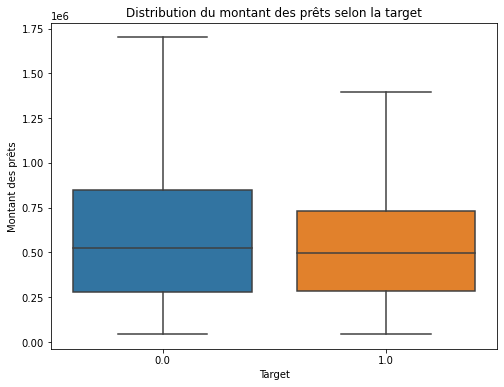

In [95]:
# Visualisation de la relation entre le montant des prêts et la target
plt.figure(figsize=(8,6))
sns.boxplot(df_application_train['TARGET'], df_application_train['AMT_CREDIT'], showfliers=False)

plt.title("Distribution du montant des prêts selon la target")
plt.ylabel("Montant des prêts")
plt.xlabel("Target")

plt.show()

Il semble que les prêts les plus importants ne soient pas accordés à des clients ayant des difficultés de paiement.

In [96]:
# Création d'un df entrainé pour l'ANOVA
df_ano = df_application_train[['TARGET', 'AMT_CREDIT']]
fit = statsmodels.formula.api.ols('TARGET ~ AMT_CREDIT', data = df_ano).fit()

# Entrainement du model et visualiation du tableau avec l'ANOVA
table = statsmodels.api.stats.anova_lm(fit)
table

,df,sum_sq,mean_sq,F,PR(>F)
AMT_CREDIT,1.0,30.055070,30.055070,391.325575,5.059041e-87
Residual,223246.0,17146.014803,0.076803,NaN,NaN


In [97]:
ser_1 = df_application_train[df_application_train.TARGET == 1].AMT_CREDIT
ser_0 = df_application_train[df_application_train.TARGET == 0].AMT_CREDIT

In [98]:
# p_value
pvalue = stats.f_oneway(ser_1,ser_0)
print("La p_value est :", pvalue)

La p_value est : F_onewayResult(statistic=391.3255751123501, pvalue=5.059041377588951e-87)


## ANOVA 
...entre le délai depuis le dernier changement de téléphone et le nombre d'individus joignables (1) par téléphone (pour vérifier s'il y a un lien entre les clients injoignables et ceux qui ont changé de numéro de téléphone récement)

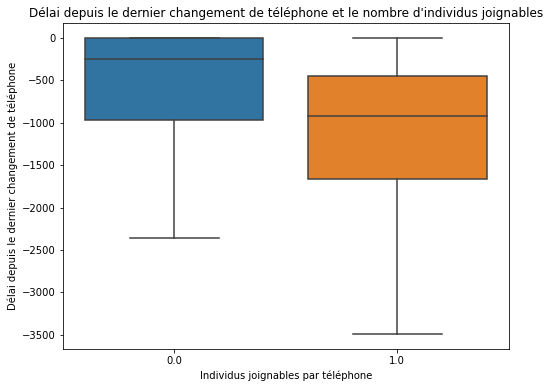

In [99]:
# Visualisation de la relation entre le délai depuis le dernier changement de téléphone et le nombre d'individus joignables
plt.figure(figsize=(8,6))
sns.boxplot(df_application_train['FLAG_CONT_MOBILE'], df_application_train['DAYS_LAST_PHONE_CHANGE'], showfliers=False)

plt.title("Délai depuis le dernier changement de téléphone et le nombre d'individus joignables")
plt.ylabel("Délai depuis le dernier changement de téléphone")
plt.xlabel("Individus joignables par téléphone")

plt.show()

Il semble que les personnes qui n'ont pas répondu au téléphone ont changer de numéro beaucoup plus récement que ceux qui ont répondu.

In [100]:
# Création d'un df entrainé pour l'ANOVA
df_ano2 = df_application_train[['FLAG_CONT_MOBILE', 'DAYS_LAST_PHONE_CHANGE']]
fit = statsmodels.formula.api.ols('FLAG_CONT_MOBILE ~ DAYS_LAST_PHONE_CHANGE', data = df_ano2).fit()

# Entrainement du model et visualiation du tableau avec l'ANOVA
table = statsmodels.api.stats.anova_lm(fit)
table

,df,sum_sq,mean_sq,F,PR(>F)
DAYS_LAST_PHONE_CHANGE,1.0,0.167560,0.167560,114.9721,8.102311e-27
Residual,223245.0,325.356393,0.001457,NaN,NaN


In [101]:
ser_1 = df_application_train[df_application_train.FLAG_CONT_MOBILE == 1].DAYS_LAST_PHONE_CHANGE
ser_0 = df_application_train[df_application_train.FLAG_CONT_MOBILE == 0].DAYS_LAST_PHONE_CHANGE

In [102]:
df_application_train.DAYS_LAST_PHONE_CHANGE.isna().value_counts()

False    223247
True      84264
Name: DAYS_LAST_PHONE_CHANGE, dtype: int64

In [103]:
# p_value
pvalue = stats.f_oneway(ser_1, ser_0)
print("La p_value est :", pvalue)

La p_value est : F_onewayResult(statistic=nan, pvalue=nan)


La p_valeur n'est pas statistiquement significative (p >0.05). Nous concluons que le faites qu'un client soit joignable n'est pas un (corrélé avec) critère qui affecte de manière significative le nombre de jour depuis lequel le client à changer de numéro de téléphone.

## ANOVA 
...entre le délai depuis le dernier changement de téléphone et la cible (pour vérifier s'il y a un lien entre les clients ayant des difficultés de paiement (1) et ceux qui ont changé de numéro de téléphone récement)

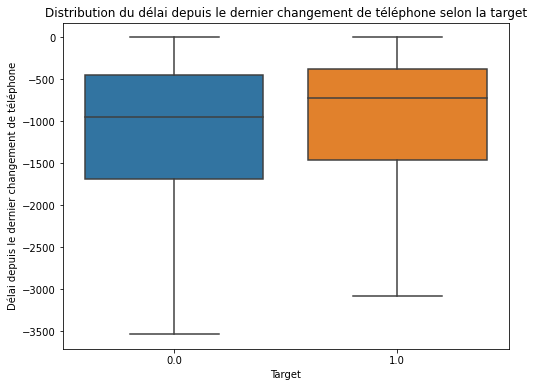

In [104]:
# Visualistion de la distribution du délai depuis le dernier changement de téléphone et la target
plt.figure(figsize=(8, 6))
sns.boxplot(df_application_train['TARGET'], df_application_train['DAYS_LAST_PHONE_CHANGE'], showfliers=False)

plt.title("Distribution du délai depuis le dernier changement de téléphone selon la target")
plt.ylabel("Délai depuis le dernier changement de téléphone")
plt.xlabel("Target")

plt.show()

Il semble que les clients ayant des difficultés de paiement aient changé leur numéro de téléphone plus récement que les autres.

In [105]:
# Création d'un df entrainé pour l'ANOVA
df_ano3 = df_application_train[['TARGET', 'DAYS_LAST_PHONE_CHANGE']]
fit = statsmodels.formula.api.ols('TARGET ~ DAYS_LAST_PHONE_CHANGE', data = df_ano3).fit()

# Entrainement du model et visualiation du tableau avec l'ANOVA
table = statsmodels.api.stats.anova_lm(fit)
table

,df,sum_sq,mean_sq,F,PR(>F)
DAYS_LAST_PHONE_CHANGE,1.0,59.240705,59.240705,772.642904,9.343995e-170
Residual,223245.0,17116.822113,0.076673,NaN,NaN


In [106]:
# Visualisation de la p_value
pvalue = stats.f_oneway(df_application_train['TARGET'], df_application_train['DAYS_LAST_PHONE_CHANGE'])
print("La p_value est :", pvalue)

La p_value est : F_onewayResult(statistic=nan, pvalue=nan)


## Chi-2
... entre le niveau d'éducation le plus élevé atteint et la target (pour vérifier si le niveau d'éducation a un impact sur les difficultés de paiement d'un individu)

https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html

In [107]:
# Affichage du tableau de contingence entre les 2 features
cont = df_application_train[['TARGET','NAME_EDUCATION_TYPE']].pivot_table(index='TARGET',columns='NAME_EDUCATION_TYPE',
                                                                          aggfunc=len, margins=False,)
cont

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
TARGET,,,,,
0.0,120,57205,7933,1682,137557
1.0,2,3245,741,259,14504


Il semble que plus le niveau académique est élevé, plus la proportion de client ayant des difficultés de paiement diminue.

In [108]:
chi2_contingency(cont)

(1047.4823942676876,
 1.8282403977915462e-225,
 4,
 array([[1.11753001e+02, 5.53726961e+04, 7.94545518e+03, 1.77797193e+03,
         1.39289124e+05],
        [1.02469989e+01, 5.07730394e+03, 7.28544820e+02, 1.63028072e+02,
         1.27718762e+04]]))

La p_valeur est statistiquement significative (p <0.05). Le niveau d'éducation a donc pas un rapport avec les difficultés de paiement d'un individu.

## Chi-2
... entre le type de revenu et la target (pour vérifier si le type de revenu a un impact sur les difficultés de paiement d'un individu)

In [109]:
# Affichage du tableau de contingence entre les 2 features
cont = df_application_train[['TARGET','NAME_INCOME_TYPE']].pivot_table(index='TARGET',columns='NAME_INCOME_TYPE', 
                                                                       aggfunc=len, margins=False,)
cont

NAME_INCOME_TYPE,Businessman,Commercial associate,Maternity leave,Pensioner,State servant,Student,Working
TARGET,,,,,,,
0.0,9.0,58867.0,3.0,9.0,18292.0,12.0,127305.0
1.0,NaN,4576.0,1.0,NaN,1091.0,NaN,13083.0


Il semble que la proportion de personnes ayant des difficultés de paiement soit très variables selon le type de revenu.

In [110]:
chi2_contingency(cont)

(nan,
 nan,
 6,
 array([[nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan]]))

La p_valeur n'est pas statistiquement significative (p >0.05). Le type de revenu n'a donc pas de rapports avec les difficultés de paiement d'un individu.

# 4. ENREGISTREMENT DU DATAFRAME FINAL

In [112]:
df.to_csv('df_fin_p7.csv', index = None)
df.shape

(307511, 148)